In [1]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
api_key = os.getenv('ALPHA_VANTAGE_API_KEY')
symbol = "CTSH"

ts = TimeSeries(key=api_key, output_format='pandas')
data, _ = ts.get_daily(symbol=symbol, outputsize='full')
data = data.rename(columns={"4. close": "Close"})
data = data[["Close"]].sort_index()

# end_date = datetime.today()
# start_date = end_date - timedelta(days=365 * 10)
# data = data.loc[start_date.strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]

In [3]:
data

,Close
date,
1999-11-01,50.88
1999-11-02,53.75
1999-11-03,52.50
1999-11-04,52.25
1999-11-05,54.75
...,...
2025-05-19,81.57
2025-05-20,80.99
2025-05-21,79.99


In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [6]:
seq_len = 60
X, y = [], []
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i - seq_len:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X).reshape(-1, seq_len, 1)
y = np.array(y)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
model = Sequential()

model.add(Input(shape=(seq_len, 1)))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer="adam", loss="mean_squared_error")

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - loss: 0.0210 - val_loss: 0.0020
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.0041 - val_loss: 8.2939e-04
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.0030 - val_loss: 9.6290e-04
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.0026 - val_loss: 8.2753e-04
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.0024 - val_loss: 3.9976e-04
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.0021 - val_loss: 4.7038e-04
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - loss: 0.0022 - val_loss: 3.5078e-04
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - loss: 0.0018 - val_loss: 3.2076e-04
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - loss: 0.0016 - val_loss: 3.7391e-04
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - loss: 0.0014 - val_loss: 2.5980e-04
Epoch 11/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.0014 - 

<Axes: >

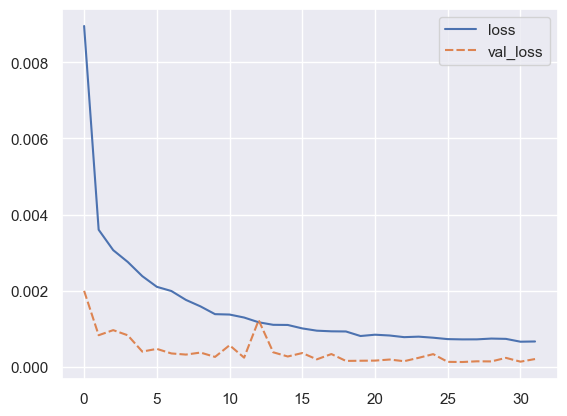

In [9]:
loss = pd.DataFrame(model.history.history)
sns.lineplot(loss)

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
n_test = 100
test_data = scaled_data[-(seq_len + n_test):]
X_test, y_true = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i - seq_len:i, 0])
    y_true.append(test_data[i, 0])
X_test = np.array(X_test).reshape(-1, seq_len, 1)

y_pred = model.predict(X_test).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_inv = scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
print(f"Test RMSE: {rmse:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
Test RMSE: 1.55


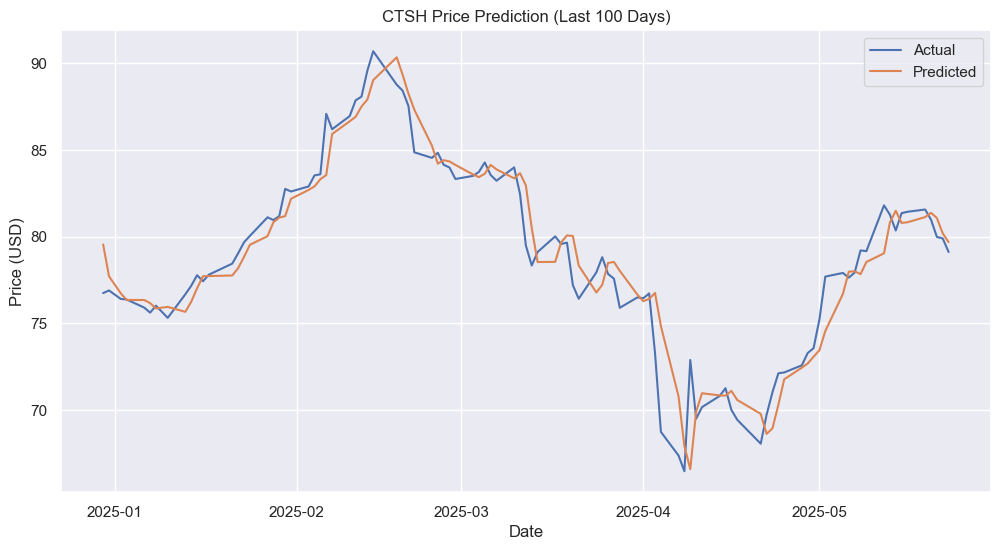

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_true_inv):], y_true_inv, label="Actual")
plt.plot(data.index[-len(y_pred_inv):], y_pred_inv, label="Predicted")
plt.title(f"{symbol} Price Prediction (Last 100 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
future_days = 10
input_seq = scaled_data[-seq_len:].reshape(1, seq_len, 1)  # last 60 days
future_preds = []

for _ in range(future_days):
    next_pred = model.predict(input_seq)[0][0]  # predict 1 step
    future_preds.append(next_pred)

    input_seq = np.append(input_seq[:, 1:, :], [[[next_pred]]], axis=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()

for i, price in enumerate(future_preds_inv, 1):
    print(f"Day {i}: ${price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Day 1: $79.14
Day 2: $78.95
Day 3: $78.87
Day 4: $78.82
Day 5: $78.78
Day 6: $78.73
Day 7: $78.68
Day 8: $78.62
Day 9: $78.57
Day 10: $78.51


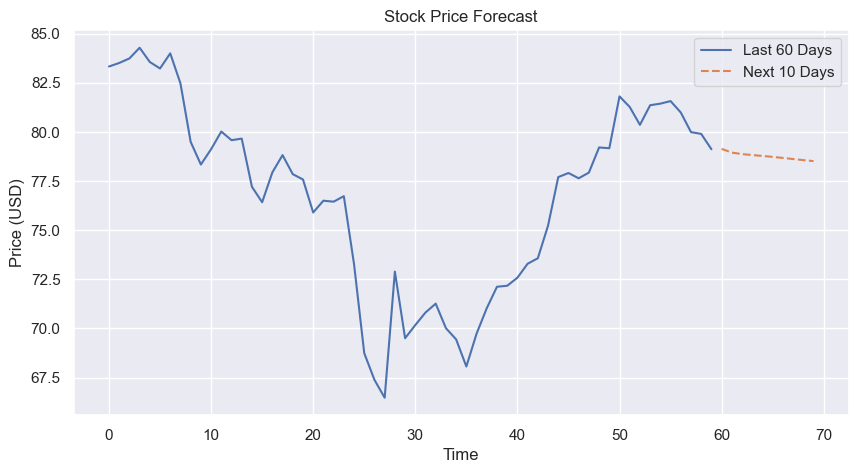

In [14]:
plt.figure(figsize=(10, 5))
recent = scaler.inverse_transform(scaled_data[-seq_len:]).flatten()
plt.plot(range(len(recent)), recent, label="Last 60 Days")
plt.plot(range(len(recent), len(recent) + future_days), future_preds_inv, label="Next 10 Days", linestyle='--')
plt.title("Stock Price Forecast")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()